# 🧠 LangGraph 흐름 실습 노트북
이 노트북은 LangGraph를 기반으로 한 음식/활동 추천 서비스를 구성하는 전체 흐름을 단계별로 실습합니다.

Streamlit 없이 Python 코드만으로 LangGraph 흐름을 실습하고, 각 노드의 동작 결과를 디버깅해보는 데 중점을 둡니다.

모든 셀에는 초급자를 위한 설명과 주석이 포함되어 있습니다. 걱정하지 말고 하나씩 따라와 주세요 😊

## 1️⃣ 필수 라이브러리 및 에이전트 함수 불러오기
먼저, 프로젝트에 필요한 모듈과 LangGraph 구성에 사용할 에이전트 함수를 불러옵니다.

In [3]:
import sys
import os
sys.path.append(os.path.abspath("../n70_agents_projects"))

In [4]:
# 필요한 라이브러리 불러오기
from langgraph.graph import StateGraph, END
from typing_extensions import TypedDict

# 프로젝트에서 정의한 에이전트들 불러오기
from agents.intent import classify_intent
from agents.time import get_time_slot
from agents.season import get_season
from agents.weather import get_weather
from agents.food import recommend_food
from agents.activity import recommend_activity
from agents.keyword import generate_search_keyword
from agents.place import search_place
from agents.summary import summarize_message
from agents.intent_unsupported import intent_unsupported_handler

## 2️⃣ 상태 정의하기 (State Type)
LangGraph는 모든 정보를 상태(State)로 전달하며 작동합니다. 여기서 우리가 처리할 정보 항목들을 정의합니다.

In [5]:
# 상태 구조 정의: LangGraph의 흐름을 구성하는 상태값입니다.
# 각 노드에서는 이 딕셔너리를 입력받고, 일부 키를 업데이트하여 다음 노드로 넘깁니다.
class State(TypedDict):
    user_input: str
    location: str
    time_slot: str
    season: str
    weather: str
    intent: str
    recommended_items: list
    search_keyword: str
    recommended_place: dict
    final_message: str

## 3️⃣ 그래프 빌더 구성하기
LangGraph에서 각 노드 함수들을 연결하여 하나의 상태 흐름으로 만듭니다.

In [6]:
# 그래프 빌더 생성
builder = StateGraph(State)

# 에이전트 노드 추가
builder.add_node("classify_intent", classify_intent)
builder.add_node("get_time_slot", get_time_slot)
builder.add_node("get_season", get_season)
builder.add_node("get_weather", get_weather)
builder.add_node("recommend_food", recommend_food)
builder.add_node("recommend_activity", recommend_activity)
builder.add_node("generate_search_keyword", generate_search_keyword)
builder.add_node("search_place", search_place)
builder.add_node("summarize_message", summarize_message)
builder.add_node("intent_unsupported", intent_unsupported_handler)

## 4️⃣ 분기 정의 및 그래프 컴파일
사용자의 의도에 따라 추천 흐름을 음식 / 활동 / 지원불가로 분기 처리합니다.

In [7]:
# 분기 함수 정의: 의도에 따라 경로를 다르게 설정
def route_intent(state: State) -> str:
    intent = state.get("intent", "")
    if intent == "food":
        return "recommend_food"
    elif intent == "activity":
        return "recommend_activity"
    return "intent_unsupported"

# 흐름 구성
builder.set_entry_point("classify_intent")
builder.add_edge("classify_intent", "get_time_slot")
builder.add_edge("get_time_slot", "get_season")
builder.add_edge("get_season", "get_weather")
builder.add_conditional_edges("get_weather", route_intent, {
    "recommend_food": "recommend_food",
    "recommend_activity": "recommend_activity",
    "intent_unsupported": "intent_unsupported"
})
builder.add_edge("recommend_food", "generate_search_keyword")
builder.add_edge("recommend_activity", "generate_search_keyword")
builder.add_edge("generate_search_keyword", "search_place")
builder.add_edge("search_place", "summarize_message")
builder.add_edge("summarize_message", END)
builder.add_edge("intent_unsupported", END)

# 그래프 컴파일
graph = builder.compile()

## 5️⃣ 테스트 실행 및 결과 확인
입력 예시를 기반으로 그래프를 실행하고, 각 단계의 출력을 확인합니다.

In [8]:
# 테스트 입력 예시
test_input = {
    "user_input": "비 오는 날 따뜻한 거 먹고 싶다",
    "location": "홍대"
}

# 그래프 실행
events = list(graph.stream(test_input))
print("✅ LangGraph 실행 완료\n")
for i, e in enumerate(events):
    print(f"Step {i+1}: {list(e.keys())[0]}")
    print(e, "\n")

# 최종 상태 출력
final_state = events[-1].get("__end__") or events[-1].get("summarize_message", {})
print("📦 최종 추천 메시지:")
print(final_state.get("final_message", "추천 결과가 없습니다."))

>>> GPT intent 응답: { "intent": ["food"] }
>>> OpenWeather API 호출 시작 (서울 기준)
>>> GPT 생성 키워드 검색: 홍대 한식
>>> GPT 생성 키워드 검색: 홍대 한식
✅ LangGraph 실행 완료

Step 1: classify_intent
{'classify_intent': {'user_input': '비 오는 날 따뜻한 거 먹고 싶다', 'location': '홍대', 'intent': 'food'}} 

Step 2: get_time_slot
{'get_time_slot': {'user_input': '비 오는 날 따뜻한 거 먹고 싶다', 'location': '홍대', 'intent': 'food', 'time_slot': '야간'}} 

Step 3: get_season
{'get_season': {'user_input': '비 오는 날 따뜻한 거 먹고 싶다', 'location': '홍대', 'time_slot': '야간', 'intent': 'food', 'season': '여름'}} 

Step 4: get_weather
{'get_weather': {'user_input': '비 오는 날 따뜻한 거 먹고 싶다', 'location': '홍대', 'time_slot': '야간', 'season': '여름', 'intent': 'food', 'weather': 'Clouds'}} 

Step 5: recommend_food
{'recommend_food': {'user_input': '비 오는 날 따뜻한 거 먹고 싶다', 'location': '홍대', 'time_slot': '야간', 'season': '여름', 'weather': 'Clouds', 'intent': 'food', 'recommended_items': ['김치찌개', '부대찌개']}} 

Step 6: generate_search_keyword
{'generate_search_keyword': {'user_input':

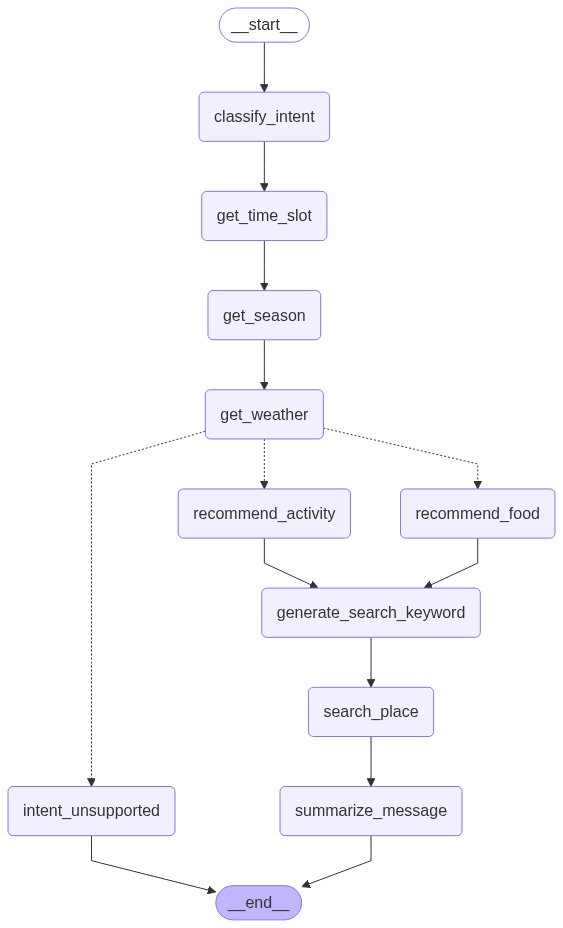

In [9]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))